In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os


In [2]:
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
# Set the path to the main folder
dataset_dir = '/content/drive/My Drive/a/'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize image to 224x224
    # transforms.RandomH(),    # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(30),        # Randomly rotate the image by up to 30 degrees
    # transforms.RandomResizedCrop(224),    # Randomly crop and resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, saturation, and hue
    # transforms.RandomGrayscale(p=0.1),    # Randomly convert the image to grayscale with a probability of 0.1
    transforms.ToTensor(),                # Convert image to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using mean and std of ImageNet
])
# Load dataset
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Get class names
class_names = dataset.classes

# Print class names
print("Class names:", class_names)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Class names: ['abbey', 'airplane_cabin', 'airport_terminal', 'alley', 'amphitheater', 'amusement_arcade', 'amusement_park', 'anechoic_chamber', 'apartment_building', 'aquarium', 'aqueduct', 'arch', 'archive', 'art_gallery', 'art_school', 'art_studio', 'assembly_line', 'attic', 'auditorium', 'auto_factory']


In [4]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 20),
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

model, criterion, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 206MB/s]


In [5]:
num_epochs = 20
losses_per_epoch = []
save_dir = "/content/drive/My Drive/ckp_aug_part"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as batch_progress:
        for inputs, labels in batch_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar with the current loss
            batch_progress.set_postfix(loss=running_loss/len(train_loader))
    # Calculate the average loss for the current epoch
    epoch_loss = running_loss / len(train_loader)
    losses_per_epoch.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

    save_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss,
    }, save_path)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')


Epoch [1/20]: 100%|██████████| 168/168 [21:06<00:00,  7.54s/it, loss=2.18]


Epoch [1/20], Loss: 2.1832247156472433
Epoch [1/20], Loss: 2.1832247156472433



Epoch [2/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [1/20]:   0%|          | 0/168 [21:06<?, ?it/s]


Epoch [2/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.0088]

Epoch [2/20]:   1%|          | 1/168 [00:00<02:06,  1.32it/s, loss=0.0088]

Epoch [2/20]:   1%|          | 1/168 [00:01<02:06,  1.32it/s, loss=0.0171]

Epoch [2/20]:   1%|          | 2/168 [00:01<02:38,  1.05it/s, loss=0.0171]

Epoch [2/20]:   1%|          | 2/168 [00:03<02:38,  1.05it/s, loss=0.0271]

Epoch [2/20]:   2%|▏         | 3/168 [00:03<03:07,  1.13s/it, loss=0.0271]

Epoch [2/20]:   2%|▏         | 3/168 [00:04<03:07,  1.13s/it, loss=0.0369]

Epoch [2/20]:   2%|▏         | 4/168 [00:04<02:58,  1.09s/it, loss=0.0369]

Epoch [2/20]:   2%|▏         | 4/168 [00:05<02:58,  1.09s/it, loss=0.0479]

Epoch [2/20]:   3%|▎         | 5/168 [00:05<02:47,  1.03s/it, loss=0.0479]

Epoch [2/20]:   3%|▎         | 5/168 [00:06<02:47,  1.03s/it, loss=0.0553]

Epoch [2/20]:   4%|▎         | 6/168 [00:06<02:47,  1.03s/it

Epoch [2/20], Loss: 1.428511069644065
Epoch [2/20], Loss: 1.428511069644065


Epoch [3/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [2/20]:   0%|          | 0/168 [02:29<?, ?it/s]


Epoch [3/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.0091]

Epoch [3/20]:   1%|          | 1/168 [00:01<03:05,  1.11s/it, loss=0.0091]

Epoch [3/20]:   1%|          | 1/168 [00:01<03:05,  1.11s/it, loss=0.0169]

Epoch [3/20]:   1%|          | 2/168 [00:01<02:16,  1.21it/s, loss=0.0169]

Epoch [3/20]:   1%|          | 2/168 [00:02<02:16,  1.21it/s, loss=0.0241]

Epoch [3/20]:   2%|▏         | 3/168 [00:02<02:17,  1.20it/s, loss=0.0241]

Epoch [3/20]:   2%|▏         | 3/168 [00:03<02:17,  1.20it/s, loss=0.0327]

Epoch [3/20]:   2%|▏         | 4/168 [00:03<02:12,  1.24it/s, loss=0.0327]

Epoch [3/20]:   2%|▏         | 4/168 [00:04<02:12,  1.24it/s, loss=0.039] 

Epoch [3/20]:   3%|▎         | 5/168 [00:04<02:12,  1.23it/s, loss=0.039]

Epoch [3/20]:   3%|▎         | 5/168 [00:04<02:12,  1.23it/s, loss=0.0469]

Epoch [3/20]:   4%|▎         | 6/168 [00:04<02:02,  1.33it/s, 

Epoch [3/20], Loss: 1.1883345331464494
Epoch [3/20], Loss: 1.1883345331464494



Epoch [4/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [3/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [4/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00625]

Epoch [4/20]:   1%|          | 1/168 [00:00<02:36,  1.07it/s, loss=0.00625]

Epoch [4/20]:   1%|          | 1/168 [00:01<02:36,  1.07it/s, loss=0.0148] 

Epoch [4/20]:   1%|          | 2/168 [00:01<02:08,  1.29it/s, loss=0.0148]

Epoch [4/20]:   1%|          | 2/168 [00:02<02:08,  1.29it/s, loss=0.0209]

Epoch [4/20]:   2%|▏         | 3/168 [00:02<02:13,  1.24it/s, loss=0.0209]

Epoch [4/20]:   2%|▏         | 3/168 [00:03<02:13,  1.24it/s, loss=0.028] 

Epoch [4/20]:   2%|▏         | 4/168 [00:03<02:04,  1.32it/s, loss=0.028]

Epoch [4/20]:   2%|▏         | 4/168 [00:03<02:04,  1.32it/s, loss=0.0357]

Epoch [4/20]:   3%|▎         | 5/168 [00:03<02:09,  1.26it/s, loss=0.0357]

Epoch [4/20]:   3%|▎         | 5/168 [00:04<02:09,  1.26it/s, loss=0.0422]

Epoch [4/20]:   4%|▎         | 6/168 [00:04<02:01,  1.33it

Epoch [4/20], Loss: 1.08097857378778
Epoch [4/20], Loss: 1.08097857378778


Epoch [5/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [4/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [5/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00559]

Epoch [5/20]:   1%|          | 1/168 [00:00<02:28,  1.13it/s, loss=0.00559]

Epoch [5/20]:   1%|          | 1/168 [00:01<02:28,  1.13it/s, loss=0.0123] 

Epoch [5/20]:   1%|          | 2/168 [00:01<02:26,  1.13it/s, loss=0.0123]

Epoch [5/20]:   1%|          | 2/168 [00:02<02:26,  1.13it/s, loss=0.0196]

Epoch [5/20]:   2%|▏         | 3/168 [00:02<02:38,  1.04it/s, loss=0.0196]

Epoch [5/20]:   2%|▏         | 3/168 [00:03<02:38,  1.04it/s, loss=0.0279]

Epoch [5/20]:   2%|▏         | 4/168 [00:03<02:15,  1.21it/s, loss=0.0279]

Epoch [5/20]:   2%|▏         | 4/168 [00:04<02:15,  1.21it/s, loss=0.0332]

Epoch [5/20]:   3%|▎         | 5/168 [00:04<02:55,  1.08s/it, loss=0.0332]

Epoch [5/20]:   3%|▎         | 5/168 [00:06<02:55,  1.08s/it, loss=0.0392]

Epoch [5/20]:   4%|▎         | 6/168 [00:06<03:08,  1.16s/

Epoch [5/20], Loss: 1.0029581462343533
Epoch [5/20], Loss: 1.0029581462343533



Epoch [5/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [6/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [6/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00544]

Epoch [6/20]:   1%|          | 1/168 [00:00<02:40,  1.04it/s, loss=0.00544]

Epoch [6/20]:   1%|          | 1/168 [00:01<02:40,  1.04it/s, loss=0.0114] 

Epoch [6/20]:   1%|          | 2/168 [00:01<02:32,  1.09it/s, loss=0.0114]

Epoch [6/20]:   1%|          | 2/168 [00:02<02:32,  1.09it/s, loss=0.0179]

Epoch [6/20]:   2%|▏         | 3/168 [00:02<02:32,  1.08it/s, loss=0.0179]

Epoch [6/20]:   2%|▏         | 3/168 [00:03<02:32,  1.08it/s, loss=0.0245]

Epoch [6/20]:   2%|▏         | 4/168 [00:03<02:27,  1.11it/s, loss=0.0245]

Epoch [6/20]:   2%|▏         | 4/168 [00:04<02:27,  1.11it/s, loss=0.031] 

Epoch [6/20]:   3%|▎         | 5/168 [00:04<02:46,  1.02s/it, loss=0.031]

Epoch [6/20]:   3%|▎         | 5/168 [00:05<02:46,  1.02s/it, loss=0.0373]

Epoch [6/20]:   4%|▎         | 6/168 [00:05<02:17,  1.18it

Epoch [6/20], Loss: 0.9363397732377052
Epoch [6/20], Loss: 0.9363397732377052


Epoch [7/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [6/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [7/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00538]

Epoch [7/20]:   1%|          | 1/168 [00:01<03:24,  1.23s/it, loss=0.00538]

Epoch [7/20]:   1%|          | 1/168 [00:01<03:24,  1.23s/it, loss=0.0108] 

Epoch [7/20]:   1%|          | 2/168 [00:01<02:18,  1.20it/s, loss=0.0108]

Epoch [7/20]:   1%|          | 2/168 [00:02<02:18,  1.20it/s, loss=0.0166]

Epoch [7/20]:   2%|▏         | 3/168 [00:02<02:23,  1.15it/s, loss=0.0166]

Epoch [7/20]:   2%|▏         | 3/168 [00:04<02:23,  1.15it/s, loss=0.0247]

Epoch [7/20]:   2%|▏         | 4/168 [00:04<03:02,  1.11s/it, loss=0.0247]

Epoch [7/20]:   2%|▏         | 4/168 [00:05<03:02,  1.11s/it, loss=0.0296]

Epoch [7/20]:   3%|▎         | 5/168 [00:05<02:56,  1.08s/it, loss=0.0296]

Epoch [7/20]:   3%|▎         | 5/168 [00:05<02:56,  1.08s/it, loss=0.0338]

Epoch [7/20]:   4%|▎         | 6/168 [00:05<02:36,  1.03it

Epoch [7/20], Loss: 0.9136168612610727
Epoch [7/20], Loss: 0.9136168612610727



Epoch [8/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [7/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [8/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00509]

Epoch [8/20]:   1%|          | 1/168 [00:00<02:22,  1.17it/s, loss=0.00509]

Epoch [8/20]:   1%|          | 1/168 [00:01<02:22,  1.17it/s, loss=0.0109] 

Epoch [8/20]:   1%|          | 2/168 [00:01<02:28,  1.12it/s, loss=0.0109]

Epoch [8/20]:   1%|          | 2/168 [00:02<02:28,  1.12it/s, loss=0.0149]

Epoch [8/20]:   2%|▏         | 3/168 [00:02<02:36,  1.05it/s, loss=0.0149]

Epoch [8/20]:   2%|▏         | 3/168 [00:03<02:36,  1.05it/s, loss=0.0206]

Epoch [8/20]:   2%|▏         | 4/168 [00:03<02:30,  1.09it/s, loss=0.0206]

Epoch [8/20]:   2%|▏         | 4/168 [00:04<02:30,  1.09it/s, loss=0.026] 

Epoch [8/20]:   3%|▎         | 5/168 [00:04<02:24,  1.13it/s, loss=0.026]

Epoch [8/20]:   3%|▎         | 5/168 [00:05<02:24,  1.13it/s, loss=0.0312]

Epoch [8/20]:   4%|▎         | 6/168 [00:05<02:41,  1.01it

Epoch [8/20], Loss: 0.8662216386624745
Epoch [8/20], Loss: 0.8662216386624745


Epoch [9/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [8/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [9/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00623]

Epoch [9/20]:   1%|          | 1/168 [00:00<01:45,  1.58it/s, loss=0.00623]

Epoch [9/20]:   1%|          | 1/168 [00:01<01:45,  1.58it/s, loss=0.00945]

Epoch [9/20]:   1%|          | 2/168 [00:01<02:35,  1.07it/s, loss=0.00945]

Epoch [9/20]:   1%|          | 2/168 [00:02<02:35,  1.07it/s, loss=0.0166] 

Epoch [9/20]:   2%|▏         | 3/168 [00:02<02:19,  1.18it/s, loss=0.0166]

Epoch [9/20]:   2%|▏         | 3/168 [00:03<02:19,  1.18it/s, loss=0.0217]

Epoch [9/20]:   2%|▏         | 4/168 [00:03<02:25,  1.13it/s, loss=0.0217]

Epoch [9/20]:   2%|▏         | 4/168 [00:04<02:25,  1.13it/s, loss=0.0265]

Epoch [9/20]:   3%|▎         | 5/168 [00:04<02:13,  1.22it/s, loss=0.0265]

Epoch [9/20]:   3%|▎         | 5/168 [00:05<02:13,  1.22it/s, loss=0.0326]

Epoch [9/20]:   4%|▎         | 6/168 [00:05<02:26,  1.10

Epoch [9/20], Loss: 0.8351271512607733
Epoch [9/20], Loss: 0.8351271512607733



Epoch [10/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [9/20]:   0%|          | 0/168 [02:29<?, ?it/s]


Epoch [10/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00408]

Epoch [10/20]:   1%|          | 1/168 [00:00<02:02,  1.36it/s, loss=0.00408]

Epoch [10/20]:   1%|          | 1/168 [00:01<02:02,  1.36it/s, loss=0.0076] 

Epoch [10/20]:   1%|          | 2/168 [00:01<02:39,  1.04it/s, loss=0.0076]

Epoch [10/20]:   1%|          | 2/168 [00:02<02:39,  1.04it/s, loss=0.0122]

Epoch [10/20]:   2%|▏         | 3/168 [00:02<02:26,  1.13it/s, loss=0.0122]

Epoch [10/20]:   2%|▏         | 3/168 [00:03<02:26,  1.13it/s, loss=0.017] 

Epoch [10/20]:   2%|▏         | 4/168 [00:03<02:18,  1.18it/s, loss=0.017]

Epoch [10/20]:   2%|▏         | 4/168 [00:04<02:18,  1.18it/s, loss=0.0229]

Epoch [10/20]:   3%|▎         | 5/168 [00:04<02:27,  1.10it/s, loss=0.0229]

Epoch [10/20]:   3%|▎         | 5/168 [00:05<02:27,  1.10it/s, loss=0.0271]

Epoch [10/20]:   4%|▎         | 6/168 [00:05<0

Epoch [10/20], Loss: 0.8051564666841712
Epoch [10/20], Loss: 0.8051564666841712


Epoch [11/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [10/20]:   0%|          | 0/168 [02:31<?, ?it/s]


Epoch [11/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00393]

Epoch [11/20]:   1%|          | 1/168 [00:01<03:43,  1.34s/it, loss=0.00393]

Epoch [11/20]:   1%|          | 1/168 [00:02<03:43,  1.34s/it, loss=0.00779]

Epoch [11/20]:   1%|          | 2/168 [00:02<03:13,  1.17s/it, loss=0.00779]

Epoch [11/20]:   1%|          | 2/168 [00:03<03:13,  1.17s/it, loss=0.0121] 

Epoch [11/20]:   2%|▏         | 3/168 [00:03<02:31,  1.09it/s, loss=0.0121]

Epoch [11/20]:   2%|▏         | 3/168 [00:03<02:31,  1.09it/s, loss=0.0169]

Epoch [11/20]:   2%|▏         | 4/168 [00:03<02:26,  1.12it/s, loss=0.0169]

Epoch [11/20]:   2%|▏         | 4/168 [00:04<02:26,  1.12it/s, loss=0.0202]

Epoch [11/20]:   3%|▎         | 5/168 [00:04<02:28,  1.10it/s, loss=0.0202]

Epoch [11/20]:   3%|▎         | 5/168 [00:05<02:28,  1.10it/s, loss=0.0251]

Epoch [11/20]:   4%|▎         | 6/168 [00:0

Epoch [11/20], Loss: 0.8010636197314376
Epoch [11/20], Loss: 0.8010636197314376



Epoch [12/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [11/20]:   0%|          | 0/168 [02:29<?, ?it/s]


Epoch [12/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00527]

Epoch [12/20]:   1%|          | 1/168 [00:01<02:50,  1.02s/it, loss=0.00527]

Epoch [12/20]:   1%|          | 1/168 [00:01<02:50,  1.02s/it, loss=0.00948]

Epoch [12/20]:   1%|          | 2/168 [00:01<02:18,  1.20it/s, loss=0.00948]

Epoch [12/20]:   1%|          | 2/168 [00:02<02:18,  1.20it/s, loss=0.0145] 

Epoch [12/20]:   2%|▏         | 3/168 [00:02<02:15,  1.21it/s, loss=0.0145]

Epoch [12/20]:   2%|▏         | 3/168 [00:03<02:15,  1.21it/s, loss=0.0195]

Epoch [12/20]:   2%|▏         | 4/168 [00:03<02:16,  1.20it/s, loss=0.0195]

Epoch [12/20]:   2%|▏         | 4/168 [00:04<02:16,  1.20it/s, loss=0.0279]

Epoch [12/20]:   3%|▎         | 5/168 [00:04<02:31,  1.08it/s, loss=0.0279]

Epoch [12/20]:   3%|▎         | 5/168 [00:05<02:31,  1.08it/s, loss=0.031] 

Epoch [12/20]:   4%|▎         | 6/168 [00:

Epoch [12/20], Loss: 0.7830174888173739
Epoch [12/20], Loss: 0.7830174888173739


Epoch [13/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [12/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [13/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00451]

Epoch [13/20]:   1%|          | 1/168 [00:00<02:36,  1.07it/s, loss=0.00451]

Epoch [13/20]:   1%|          | 1/168 [00:02<02:36,  1.07it/s, loss=0.0101] 

Epoch [13/20]:   1%|          | 2/168 [00:02<02:52,  1.04s/it, loss=0.0101]

Epoch [13/20]:   1%|          | 2/168 [00:03<02:52,  1.04s/it, loss=0.013] 

Epoch [13/20]:   2%|▏         | 3/168 [00:03<02:50,  1.03s/it, loss=0.013]

Epoch [13/20]:   2%|▏         | 3/168 [00:03<02:50,  1.03s/it, loss=0.0177]

Epoch [13/20]:   2%|▏         | 4/168 [00:03<02:19,  1.18it/s, loss=0.0177]

Epoch [13/20]:   2%|▏         | 4/168 [00:04<02:19,  1.18it/s, loss=0.0223]

Epoch [13/20]:   3%|▎         | 5/168 [00:04<02:06,  1.29it/s, loss=0.0223]

Epoch [13/20]:   3%|▎         | 5/168 [00:05<02:06,  1.29it/s, loss=0.0275]

Epoch [13/20]:   4%|▎         | 6/168 [00:05<0

Epoch [13/20], Loss: 0.7556122507722605
Epoch [13/20], Loss: 0.7556122507722605



Epoch [14/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [13/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [14/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00678]

Epoch [14/20]:   1%|          | 1/168 [00:01<04:02,  1.45s/it, loss=0.00678]

Epoch [14/20]:   1%|          | 1/168 [00:02<04:02,  1.45s/it, loss=0.0122] 

Epoch [14/20]:   1%|          | 2/168 [00:02<03:02,  1.10s/it, loss=0.0122]

Epoch [14/20]:   1%|          | 2/168 [00:03<03:02,  1.10s/it, loss=0.0165]

Epoch [14/20]:   2%|▏         | 3/168 [00:03<02:50,  1.03s/it, loss=0.0165]

Epoch [14/20]:   2%|▏         | 3/168 [00:04<02:50,  1.03s/it, loss=0.02]  

Epoch [14/20]:   2%|▏         | 4/168 [00:04<03:01,  1.11s/it, loss=0.02]

Epoch [14/20]:   2%|▏         | 4/168 [00:04<03:01,  1.11s/it, loss=0.0228]

Epoch [14/20]:   3%|▎         | 5/168 [00:04<02:24,  1.13it/s, loss=0.0228]

Epoch [14/20]:   3%|▎         | 5/168 [00:06<02:24,  1.13it/s, loss=0.0259]

Epoch [14/20]:   4%|▎         | 6/168 [00:06<0

Epoch [14/20], Loss: 0.7523820100440866
Epoch [14/20], Loss: 0.7523820100440866


Epoch [15/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [14/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [15/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00382]

Epoch [15/20]:   1%|          | 1/168 [00:00<02:41,  1.03it/s, loss=0.00382]

Epoch [15/20]:   1%|          | 1/168 [00:02<02:41,  1.03it/s, loss=0.00641]

Epoch [15/20]:   1%|          | 2/168 [00:02<03:31,  1.27s/it, loss=0.00641]

Epoch [15/20]:   1%|          | 2/168 [00:03<03:31,  1.27s/it, loss=0.0114] 

Epoch [15/20]:   2%|▏         | 3/168 [00:03<03:05,  1.12s/it, loss=0.0114]

Epoch [15/20]:   2%|▏         | 3/168 [00:04<03:05,  1.12s/it, loss=0.0166]

Epoch [15/20]:   2%|▏         | 4/168 [00:04<02:48,  1.03s/it, loss=0.0166]

Epoch [15/20]:   2%|▏         | 4/168 [00:04<02:48,  1.03s/it, loss=0.0213]

Epoch [15/20]:   3%|▎         | 5/168 [00:04<02:18,  1.18it/s, loss=0.0213]

Epoch [15/20]:   3%|▎         | 5/168 [00:05<02:18,  1.18it/s, loss=0.0261]

Epoch [15/20]:   4%|▎         | 6/168 [00:0

Epoch [15/20], Loss: 0.7190122157335281
Epoch [15/20], Loss: 0.7190122157335281



Epoch [16/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [15/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [16/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00304]

Epoch [16/20]:   1%|          | 1/168 [00:00<02:16,  1.22it/s, loss=0.00304]

Epoch [16/20]:   1%|          | 1/168 [00:01<02:16,  1.22it/s, loss=0.00761]

Epoch [16/20]:   1%|          | 2/168 [00:01<02:35,  1.07it/s, loss=0.00761]

Epoch [16/20]:   1%|          | 2/168 [00:02<02:35,  1.07it/s, loss=0.0133] 

Epoch [16/20]:   2%|▏         | 3/168 [00:02<02:42,  1.02it/s, loss=0.0133]

Epoch [16/20]:   2%|▏         | 3/168 [00:03<02:42,  1.02it/s, loss=0.0166]

Epoch [16/20]:   2%|▏         | 4/168 [00:03<02:33,  1.07it/s, loss=0.0166]

Epoch [16/20]:   2%|▏         | 4/168 [00:04<02:33,  1.07it/s, loss=0.0225]

Epoch [16/20]:   3%|▎         | 5/168 [00:04<02:32,  1.07it/s, loss=0.0225]

Epoch [16/20]:   3%|▎         | 5/168 [00:05<02:32,  1.07it/s, loss=0.0249]

Epoch [16/20]:   4%|▎         | 6/168 [00:

Epoch [16/20], Loss: 0.7211268655955791
Epoch [16/20], Loss: 0.7211268655955791


Epoch [17/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [16/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [17/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00512]

Epoch [17/20]:   1%|          | 1/168 [00:00<02:26,  1.14it/s, loss=0.00512]

Epoch [17/20]:   1%|          | 1/168 [00:01<02:26,  1.14it/s, loss=0.0101] 

Epoch [17/20]:   1%|          | 2/168 [00:01<02:10,  1.27it/s, loss=0.0101]

Epoch [17/20]:   1%|          | 2/168 [00:02<02:10,  1.27it/s, loss=0.0126]

Epoch [17/20]:   2%|▏         | 3/168 [00:02<02:20,  1.17it/s, loss=0.0126]

Epoch [17/20]:   2%|▏         | 3/168 [00:03<02:20,  1.17it/s, loss=0.018] 

Epoch [17/20]:   2%|▏         | 4/168 [00:03<02:28,  1.10it/s, loss=0.018]

Epoch [17/20]:   2%|▏         | 4/168 [00:04<02:28,  1.10it/s, loss=0.0214]

Epoch [17/20]:   3%|▎         | 5/168 [00:04<02:18,  1.18it/s, loss=0.0214]

Epoch [17/20]:   3%|▎         | 5/168 [00:05<02:18,  1.18it/s, loss=0.0252]

Epoch [17/20]:   4%|▎         | 6/168 [00:05<0

Epoch [17/20], Loss: 0.7071409409954434
Epoch [17/20], Loss: 0.7071409409954434



Epoch [18/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [17/20]:   0%|          | 0/168 [02:31<?, ?it/s]


Epoch [18/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00498]

Epoch [18/20]:   1%|          | 1/168 [00:00<02:44,  1.02it/s, loss=0.00498]

Epoch [18/20]:   1%|          | 1/168 [00:01<02:44,  1.02it/s, loss=0.00937]

Epoch [18/20]:   1%|          | 2/168 [00:01<02:00,  1.38it/s, loss=0.00937]

Epoch [18/20]:   1%|          | 2/168 [00:02<02:00,  1.38it/s, loss=0.013]  

Epoch [18/20]:   2%|▏         | 3/168 [00:02<01:49,  1.50it/s, loss=0.013]

Epoch [18/20]:   2%|▏         | 3/168 [00:02<01:49,  1.50it/s, loss=0.0169]

Epoch [18/20]:   2%|▏         | 4/168 [00:02<01:44,  1.57it/s, loss=0.0169]

Epoch [18/20]:   2%|▏         | 4/168 [00:03<01:44,  1.57it/s, loss=0.0194]

Epoch [18/20]:   3%|▎         | 5/168 [00:03<01:49,  1.49it/s, loss=0.0194]

Epoch [18/20]:   3%|▎         | 5/168 [00:04<01:49,  1.49it/s, loss=0.0235]

Epoch [18/20]:   4%|▎         | 6/168 [00:0

Epoch [18/20], Loss: 0.6920113517414956
Epoch [18/20], Loss: 0.6920113517414956


Epoch [19/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [18/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [19/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00332]

Epoch [19/20]:   1%|          | 1/168 [00:01<04:05,  1.47s/it, loss=0.00332]

Epoch [19/20]:   1%|          | 1/168 [00:02<04:05,  1.47s/it, loss=0.00631]

Epoch [19/20]:   1%|          | 2/168 [00:02<03:14,  1.17s/it, loss=0.00631]

Epoch [19/20]:   1%|          | 2/168 [00:03<03:14,  1.17s/it, loss=0.0107] 

Epoch [19/20]:   2%|▏         | 3/168 [00:03<02:48,  1.02s/it, loss=0.0107]

Epoch [19/20]:   2%|▏         | 3/168 [00:03<02:48,  1.02s/it, loss=0.0149]

Epoch [19/20]:   2%|▏         | 4/168 [00:03<02:27,  1.11it/s, loss=0.0149]

Epoch [19/20]:   2%|▏         | 4/168 [00:04<02:27,  1.11it/s, loss=0.0192]

Epoch [19/20]:   3%|▎         | 5/168 [00:04<02:08,  1.27it/s, loss=0.0192]

Epoch [19/20]:   3%|▎         | 5/168 [00:05<02:08,  1.27it/s, loss=0.0232]

Epoch [19/20]:   4%|▎         | 6/168 [00:0

Epoch [19/20], Loss: 0.6861717794977483
Epoch [19/20], Loss: 0.6861717794977483



Epoch [20/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [19/20]:   0%|          | 0/168 [02:30<?, ?it/s]


Epoch [20/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.0039]

Epoch [20/20]:   1%|          | 1/168 [00:00<01:53,  1.47it/s, loss=0.0039]

Epoch [20/20]:   1%|          | 1/168 [00:01<01:53,  1.47it/s, loss=0.00937]

Epoch [20/20]:   1%|          | 2/168 [00:01<02:49,  1.02s/it, loss=0.00937]

Epoch [20/20]:   1%|          | 2/168 [00:03<02:49,  1.02s/it, loss=0.0128] 

Epoch [20/20]:   2%|▏         | 3/168 [00:03<02:59,  1.09s/it, loss=0.0128]

Epoch [20/20]:   2%|▏         | 3/168 [00:04<02:59,  1.09s/it, loss=0.0185]

Epoch [20/20]:   2%|▏         | 4/168 [00:04<03:01,  1.11s/it, loss=0.0185]

Epoch [20/20]:   2%|▏         | 4/168 [00:04<03:01,  1.11s/it, loss=0.0224]

Epoch [20/20]:   3%|▎         | 5/168 [00:04<02:32,  1.07it/s, loss=0.0224]

Epoch [20/20]:   3%|▎         | 5/168 [00:05<02:32,  1.07it/s, loss=0.0282]

Epoch [20/20]:   4%|▎         | 6/168 [00:05

Epoch [20/20], Loss: 0.6632941620690482
Epoch [20/20], Loss: 0.6632941620690482


# Evaluation

In [6]:
print("\nLoss for each epoch:")
for epoch, loss in enumerate(losses_per_epoch, 1):
    print(f"Epoch {epoch}: {loss}")


Loss for each epoch:
Epoch 1: 2.1832247156472433
Epoch 2: 1.428511069644065
Epoch 3: 1.1883345331464494
Epoch 4: 1.08097857378778
Epoch 5: 1.0029581462343533
Epoch 6: 0.9363397732377052
Epoch 7: 0.9136168612610727
Epoch 8: 0.8662216386624745
Epoch 9: 0.8351271512607733
Epoch 10: 0.8051564666841712
Epoch 11: 0.8010636197314376
Epoch 12: 0.7830174888173739
Epoch 13: 0.7556122507722605
Epoch 14: 0.7523820100440866
Epoch 15: 0.7190122157335281
Epoch 16: 0.7211268655955791
Epoch 17: 0.7071409409954434
Epoch 18: 0.6920113517414956
Epoch 19: 0.6861717794977483
Epoch 20: 0.6632941620690482


<ipython-input-7-58f6897df61d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Evaluating: 100%|██████████| 42/42 [06:55<00:00,  9.

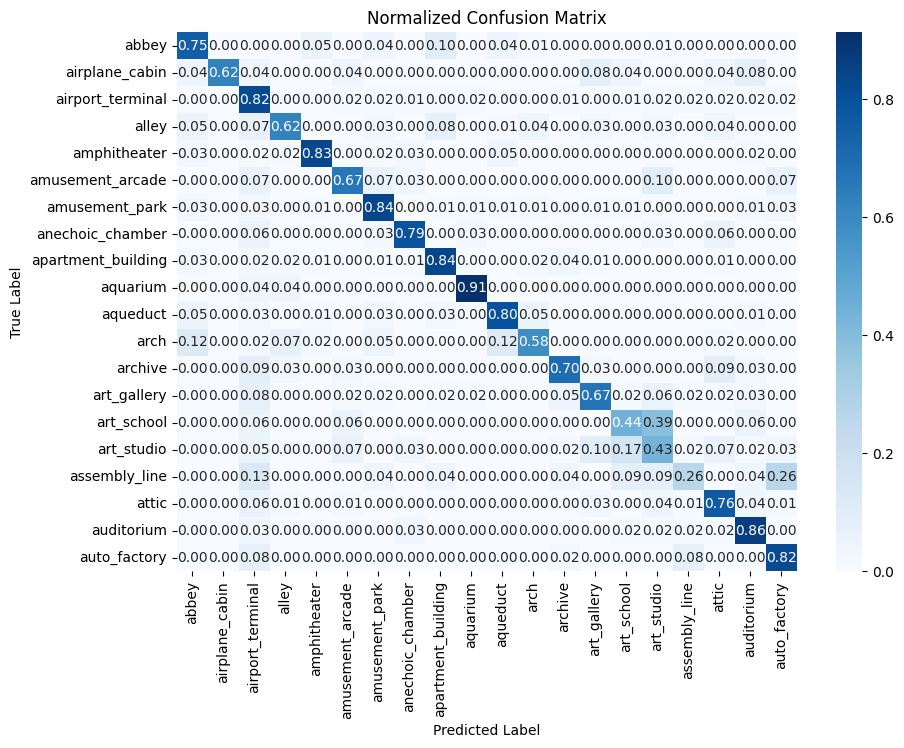

In [7]:
checkpoint_path = '/content/drive/My Drive/ckp_aug_part/model_epoch_20.pth'

# Load the saved checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        # Move inputs and labels to device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        # Append true and predicted labels to respective lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix to range [0, 1]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.show()


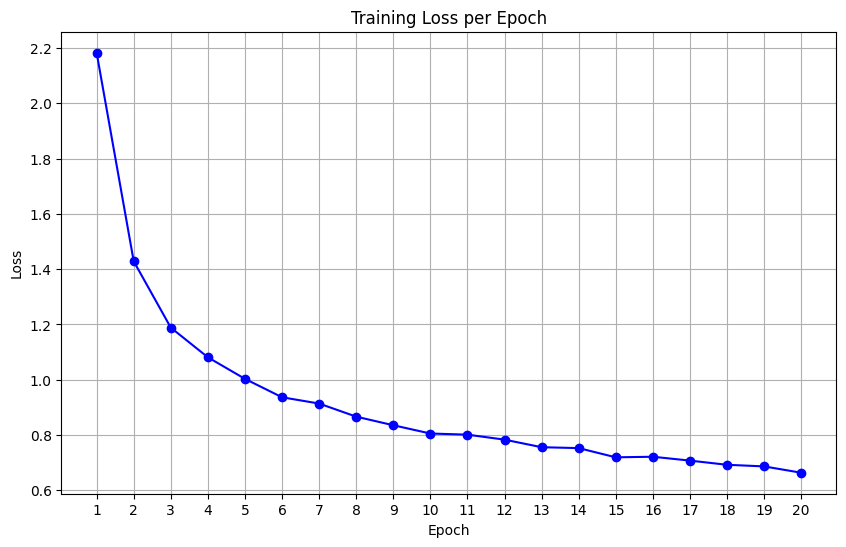

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_per_epoch) + 1), losses_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, len(losses_per_epoch) + 1))  # Set x-axis ticks for each epoch
plt.show()

In [9]:
# Calculate accuracy for the last epoch
correct_predictions = 0
total_predictions = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(train_loader, desc="Evaluating last epoch"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate accuracy
last_epoch_accuracy = correct_predictions / total_predictions * 100  # Convert to percentage

# Print accuracy for the last epoch
print(f"Accuracy for the last epoch [{epoch}]: {last_epoch_accuracy:.2f}%")

Evaluating last epoch: 100%|██████████| 168/168 [02:23<00:00,  1.17it/s]

Accuracy for the last epoch [20]: 81.86%


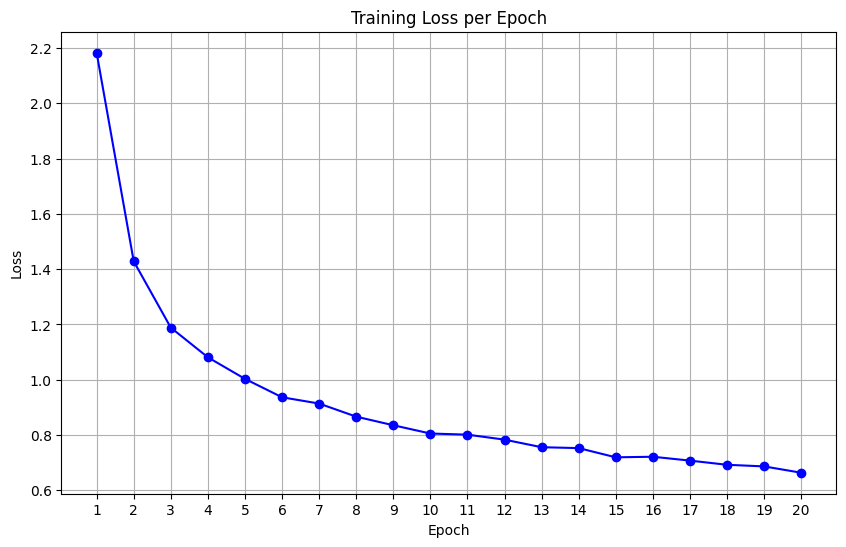

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_per_epoch) + 1), losses_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, len(losses_per_epoch) + 1))  # Set x-axis ticks for each epoch
plt.show()